## HOME CREDIT DEFAULT RISK
This kernel will contain EDA, visualization, feature engineering and some modelling. Work currently in progress.

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns

import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

import os
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("max_columns", 150)

There are several files with data, let's go through them step by step.

In [72]:
folder = "../input/home-credit-default-risk/"
application_train = pd.read_csv(os.path.join(folder, "application_train.csv"))
application_test = pd.read_csv(os.path.join(folder, "application_test.csv"))
bureau = pd.read_csv(os.path.join(folder, "bureau.csv"))
bureau_balance = pd.read_csv(os.path.join(folder, "bureau_balance.csv"))
POS_CASH_balacne = pd.read_csv(os.path.join(folder, "POS_CASH_balance.csv"))
credit_card_balance = pd.read_csv(os.path.join(folder, "credit_card_balance.csv"))
previous_application = pd.read_csv(os.path.join(folder, "previous_application.csv"))
installments_payments = pd.read_csv(os.path.join(folder, "installments_payments.csv"))
sample_submission = pd.read_csv(os.path.join(folder, "sample_submission.csv"))

## Data Exploration   

### application_train & application_test
These are main files with data and technically we can use only them to make predictions. Obviously using additional data is necessary to improve score.

In [73]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

We have 122 columns in just main file! Let's take a look on some of them.

### Categorical Features

*Target*

In [74]:
application_train.TARGET.value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

We have imbalanced target, though disbalance isn't really serious.  

*NAME_CONTRACT_TYPE*

In [75]:
pd.crosstab(application_train.TARGET, application_train.NAME_CONTRACT_TYPE, dropna=False, normalize="all")

NAME_CONTRACT_TYPE,Cash loans,Revolving loans
TARGET,,
0,0.829274,0.089997
1,0.075513,0.005216


We can see that there are two types of contract - cash loans & revolving loans.   
Most of the loans are cash loans which are defaulted.


*CODE_GENDER*

In [76]:
pd.crosstab(application_train.TARGET, application_train.CODE_GENDER, dropna=False)

CODE_GENDER,F,M,XNA
TARGET,,,
0,188278,94404,4
1,14170,10655,0


We can see that women take more loads and higher percentage of them repays the loans. And there are 4 people with unindentified gender, who repayed their loans.


*FLAG_OWN_CAR & FLAG_OWN_REALTY*

In [77]:
print("There are {0} people with realty. {1}% of them repay loans.".format(application_train[application_train.FLAG_OWN_REALTY == "Y"].shape[0],
                                                                           np.round(application_train[application_train.FLAG_OWN_REALTY == "Y"].TARGET.value_counts(normalize=True).values[1], 3)*100))
print("There are {0} people with cars. {1}% of them repay loans.".format(application_train[application_train.FLAG_OWN_CAR == "Y"].shape[0],
                                                                         np.round(application_train[application_train.FLAG_OWN_CAR == "Y"].TARGET.value_counts(normalize=True).values[1], 4)*100))
print("Average age of the car is {:.2f} years.".format(application_train.groupby(["FLAG_OWN_CAR"])["OWN_CAR_AGE"].mean().values[1]))
                                ## 소수점 아래 두번째 자리까지

There are 213312 people with realty. 8.0% of them repay loans.
There are 104587 people with cars. 7.24% of them repay loans.
Average age of the car is 12.06 years.


*CNT_CHILDREN & NAME_FAMILY_STATUS*

In [78]:
pd.crosstab(application_train.CNT_CHILDREN, application_train.NAME_FAMILY_STATUS, dropna=False)

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
CNT_CHILDREN,,,,,,
0,20947,126575,14132,38810,2,14905
1,6588,43696,4389,5578,0,868
2,1936,22496,1111,958,0,248
3,262,3190,122,85,0,58
4,33,370,12,9,0,5
5,5,74,2,1,0,2
6,2,17,1,0,0,1
7,1,5,0,0,0,1
8,0,2,0,0,0,0


We can see that most of the people are married and have 0 children. In face we can divide people into two group based on their family status - living togerther with their partner or single.

In [79]:
pd.crosstab(application_train.CNT_CHILDREN, application_train.CNT_FAM_MEMBERS, dropna=False)

CNT_FAM_MEMBERS,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,20.0
CNT_CHILDREN,,,,,,,,,,,,,,,,,
0,67847,147522,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,10835,50284,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2317,24432,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,265,3452,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,26,403,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,5,79,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,2,19,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,6,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0


It isn't surprising that there are a lot of families consisting of two or one adults. Also there are families with two adults and 1-2 children.     

*NAME_TYPE_SUITE*  
This feature shows who was accompanying client when he was applying for the loan. (동반 고객)

In [80]:
application_train["NAME_TYPE_SUITE"].value_counts(dropna=False)

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
NaN                  1292
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [81]:
pd.crosstab(application_train.NAME_TYPE_SUITE, application_train.NAME_FAMILY_STATUS, dropna=False)

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
NAME_TYPE_SUITE,,,,,,
Children,253,1940,318,378,0,378
Family,3702,28617,1747,4150,0,1933
Group of people,29,165,20,44,0,13
Other_A,147,340,70,268,0,41
Other_B,171,854,132,486,0,127
"Spouse, partner",1247,9685,74,345,0,19
Unaccompanied,24112,154047,17334,39529,0,13504


It is interesting to see that these two variables sometimes contradict each other.   
For example, separated, single or widowed applicants were sometimes accompnied by their partner. 


Q1. This means unofficial relationships?  
Q2. Also, sometimes children accompanied the applicant. Maybe these were adult children?     



*NAME_INCOME_TYPE*

In [82]:
application_train.groupby(["NAME_INCOME_TYPE"]).agg({"AMT_INCOME_TOTAL" : ["mean", "median", "count"]})

AMT_INCOME_TOTAL                  
                                 mean    median   count
NAME_INCOME_TYPE                                       
Businessman             652500.000000  495000.0      10
Commercial associate    202955.327289  180000.0   71617
Maternity leave         140400.000000   90000.0       5
Pensioner               136401.292273  117000.0   55362
State servant           179737.969506  157500.0   21703
Student                 170500.000000  157500.0      18
Unemployed              110536.363636   78750.0      22
Working                 163169.889223  135000.0  158774

In [83]:
application_train[application_train["NAME_INCOME_TYPE"]=="Maternity leave"]["CODE_GENDER"].value_counts()

F    4
M    1
Name: CODE_GENDER, dtype: int64

We can see that there are 4 categories with little amount of people in them :   
several high-income businessment, 4 women and 1 man on maternity leave, and some unemployed/students. It is quite interesting that unemployed/students have quite a high income. And of course, msot of the people work.

In [84]:
s = pd.crosstab(application_train.NAME_INCOME_TYPE, application_train.OCCUPATION_TYPE, dropna=False).style.background_gradient(cmap="viridis", low=.5, high=0).highlight_null("red")

s

OCCUPATION_TYPE,Accountants,Cleaning staff,Cooking staff,Core staff,Drivers,HR staff,High skill tech staff,IT staff,Laborers,Low-skill Laborers,Managers,Medicine staff,Private service staff,Realty agents,Sales staff,Secretaries,Security staff,Waiters/barmen staff
NAME_INCOME_TYPE,,,,,,,,,,,,,,,,,,
Businessman,0,0,0,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0
Commercial associate,3970,892,1305,6528,4916,220,3495,204,12763,370,8916,1036,989,324,11104,343,1559,386
Maternity leave,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Pensioner,0,2,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
State servant,729,261,453,6956,815,64,1033,55,1868,25,2142,2585,38,9,186,264,380,53
Student,1,0,0,3,1,0,0,0,5,2,0,0,0,0,0,0,0,1
Working,5112,3498,4188,14080,12871,279,6852,267,40548,1696,10306,4915,1625,418,20811,698,4782,908


*AMT_GOODS_PRICE*   
For consumer loans, it is the price of the goods for which the loan is given.

In [85]:
print("{0} zero values.".format(application_train[application_train["AMT_GOODS_PRICE"].isnull()].shape[0]))

278 zero values.


So this means that only 278 loans have some other type. Let's go deeper.

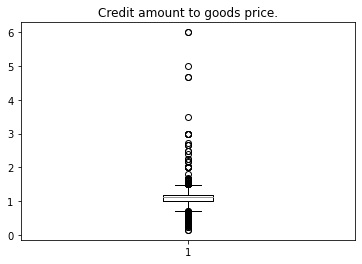

In [86]:
non_zero_good_price = application_train[application_train["AMT_GOODS_PRICE"].isnull()==False]
credit_to_good_price = non_zero_good_price["AMT_CREDIT"]/non_zero_good_price["AMT_GOODS_PRICE"]

plt.boxplot(credit_to_good_price)
plt.title("Credit amount to goods price.");

We can see that most of the loans have the amount which is similar to the goods price, but there are some outliers.   


*NAME_HOUSING_TYPE*

Text(0.5, 1.0, 'Counts of housing type')

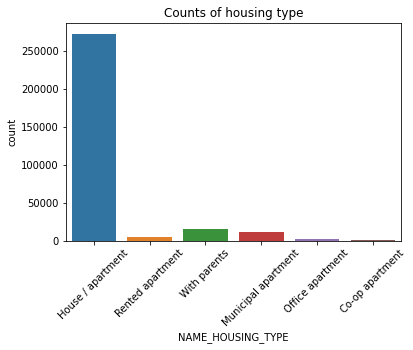

In [87]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

sns.countplot(application_train["NAME_HOUSING_TYPE"]);
plt.xticks(rotation=45);
plt.title("Counts of housing type")

*Contact information*   
There are 6 features showing that client provided some contact information, let's see how many ways of contact clients usually provide.

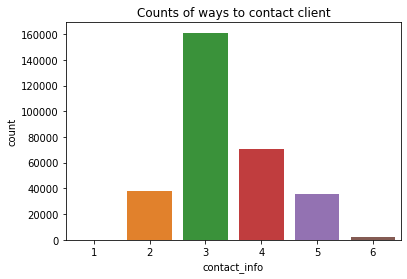

In [88]:
application_train["contact_info"] = application_train["FLAG_MOBIL"] + application_train["FLAG_EMP_PHONE"] + application_train["FLAG_WORK_PHONE"] + application_train["FLAG_CONT_MOBILE"] + application_train["FLAG_PHONE"] + application_train["FLAG_EMAIL"]

sns.countplot(application_train["contact_info"]);
plt.title("Counts of ways to contact client");

Most clients provide 3 ways to contact them and usually minimus is 2, if we don't consider several people who left only 1.

## Deliquencies  
It is very important to see how many times clients was late with payments or defaulted his loans. Let's suppose info about his social circle is also important, and divide values into 2 groups : 0, 1 and more than 1.

In [89]:
application_train.loc[application_train["OBS_30_CNT_SOCIAL_CIRCLE"] > 1, "OBS_30_CNT_SOCIAL_CIRCLE"] = "1+"
application_train.loc[application_train["DEF_30_CNT_SOCIAL_CIRCLE"] > 1, "DEF_30_CNT_SOCIAL_CIRCLE"] = "1+"
application_train.loc[application_train["OBS_60_CNT_SOCIAL_CIRCLE"] > 1, "OBS_60_CNT_SOCIAL_CIRCLE"] = "1+"
application_train.loc[application_train["DEF_60_CNT_SOCIAL_CIRCLE"] > 1, "DEF_60_CNT_SOCIAL_CIRCLE"] = "1+"

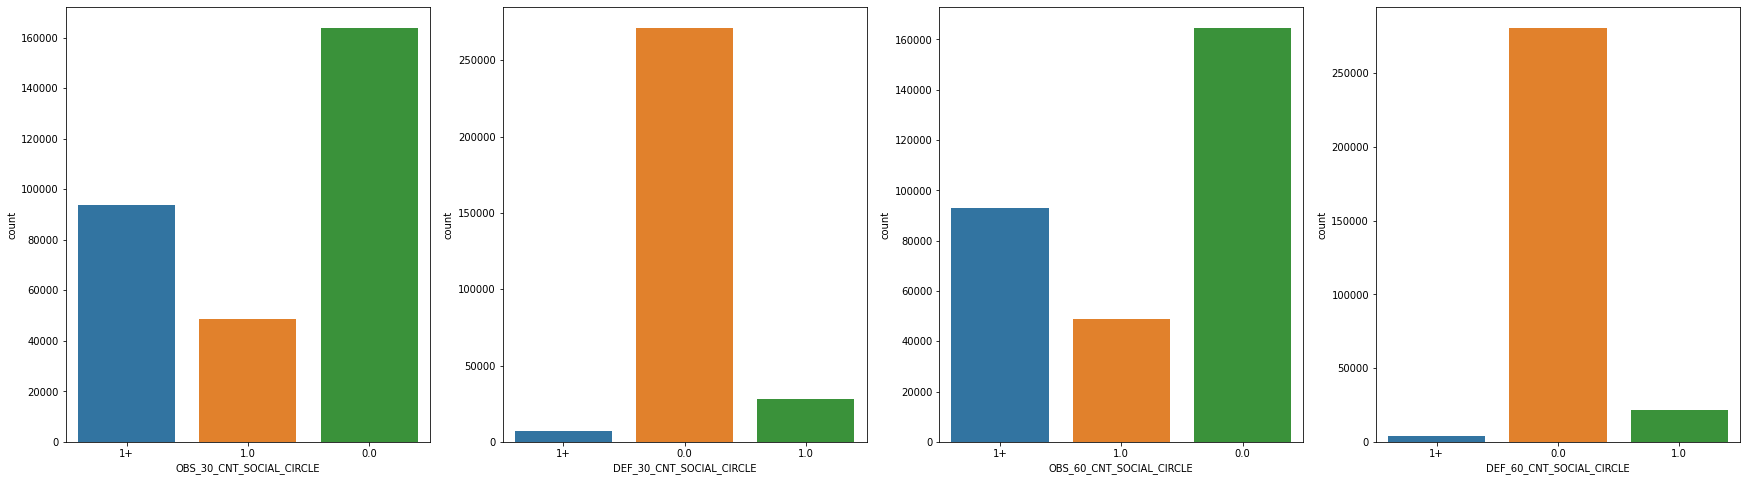

In [90]:
fig, ax = plt.subplots(figsize=(30, 8))

plt.subplot(1, 4, 1)
sns.countplot(application_train["OBS_30_CNT_SOCIAL_CIRCLE"]);

plt.subplot(1, 4, 2)
sns.countplot(application_train["DEF_30_CNT_SOCIAL_CIRCLE"]);

plt.subplot(1, 4, 3)
sns.countplot(application_train["OBS_60_CNT_SOCIAL_CIRCLE"]);

plt.subplot(1, 4, 4)
sns.countplot(application_train["DEF_60_CNT_SOCIAL_CIRCLE"]);

### Continuous variables

*AMT_INCOME_TOTAL*

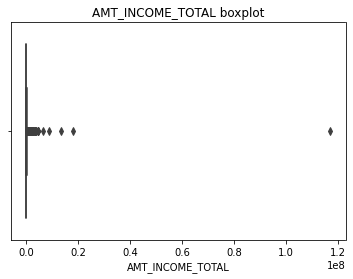

In [91]:
sns.boxplot(application_train["AMT_INCOME_TOTAL"]);
plt.title("AMT_INCOME_TOTAL boxplot");

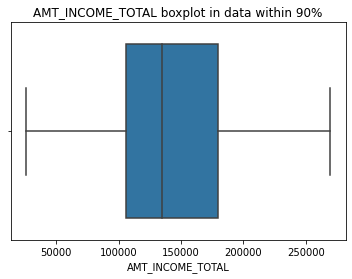

In [92]:
sns.boxplot(application_train[application_train["AMT_INCOME_TOTAL"] < np.percentile(application_train["AMT_INCOME_TOTAL"], 90)]["AMT_INCOME_TOTAL"]);
plt.title("AMT_INCOME_TOTAL boxplot in data within 90%");

In [93]:
application_train.groupby("TARGET").agg({"AMT_INCOME_TOTAL" : ["mean", "median", "count"]})

AMT_INCOME_TOTAL                  
                   mean    median   count
TARGET                                   
0         169077.722266  148500.0  282686
1         165611.760906  135000.0   24825

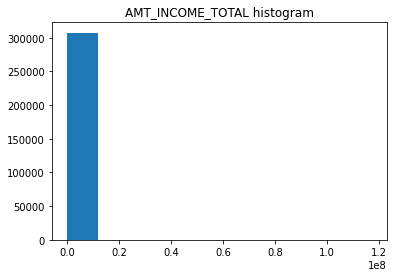

In [94]:
plt.hist(application_train["AMT_INCOME_TOTAL"]);
plt.title("AMT_INCOME_TOTAL histogram");

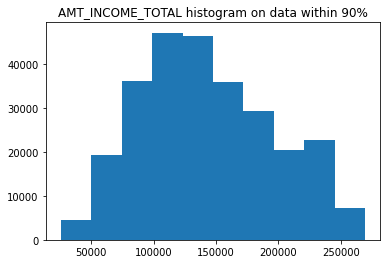

In [95]:
plt.hist(application_train[application_train["AMT_INCOME_TOTAL"] < np.percentile(application_train["AMT_INCOME_TOTAL"], 90)]["AMT_INCOME_TOTAL"]);
plt.title("AMT_INCOME_TOTAL histogram on data within 90%");

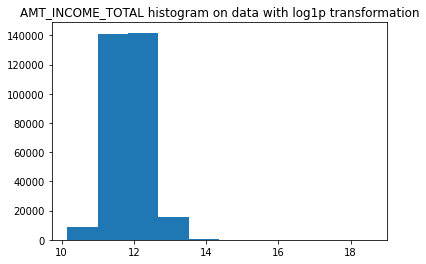

In [96]:
plt.hist(np.log1p(application_train["AMT_INCOME_TOTAL"])); ## log1p(x) = ln(1+x)
plt.title("AMT_INCOME_TOTAL histogram on data with log1p transformation");

We can see following things from the information above:  
* income feature hat some huge outliers. This could be due to rich individuals or due to errors in data.  
* average income is almost similar for those who repay the loans and those who don't.  
* if we leave only data within 90 percentile, it is almost normally distributed.   
* log transformation also helps.

*AMT_CREDIT*

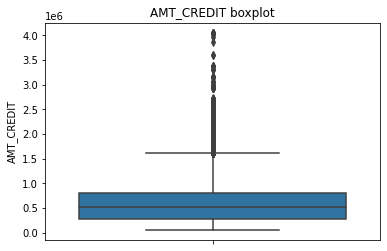

In [97]:
sns.boxplot(y=application_train["AMT_CREDIT"]);
plt.title("AMT_CREDIT boxplot");

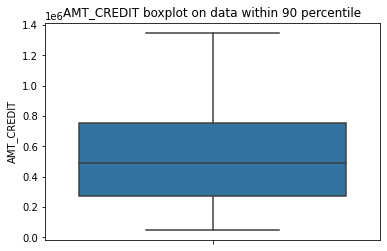

In [98]:
sns.boxplot(y=application_train[application_train["AMT_CREDIT"] < np.percentile(application_train["AMT_CREDIT"], 95)]["AMT_CREDIT"]);
plt.title("AMT_CREDIT boxplot on data within 90 percentile");

In [99]:
application_train.groupby("TARGET").agg({"AMT_CREDIT" : ["mean", "median", "count"]})

AMT_CREDIT                  
                 mean    median   count
TARGET                                 
0       602648.282002  517788.0  282686
1       557778.527674  497520.0   24825

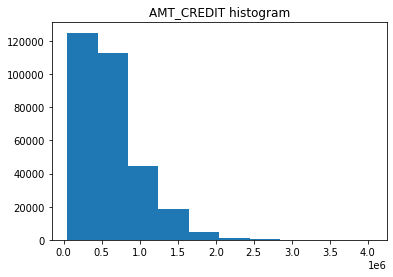

In [100]:
plt.hist(application_train["AMT_CREDIT"]);
plt.title("AMT_CREDIT histogram");

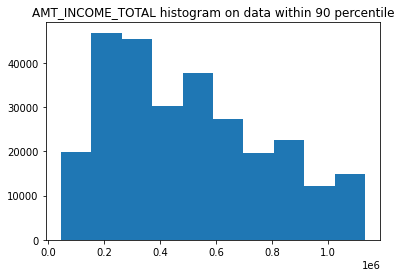

In [101]:
plt.hist(application_train[application_train["AMT_CREDIT"] < np.percentile(application_train["AMT_CREDIT"], 90)]["AMT_CREDIT"]);
plt.title("AMT_INCOME_TOTAL histogram on data within 90 percentile");

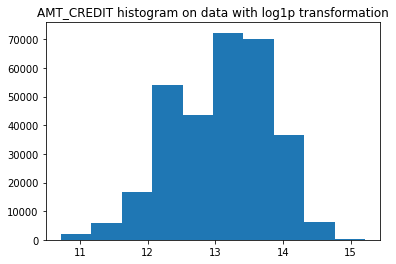

In [102]:
plt.hist(np.log1p(application_train["AMT_CREDIT"]));
plt.title("AMT_CREDIT histogram on data with log1p transformation");

This feature shows the amount of the loan in question. We can see following things from the information above:  
* income feature has some outliers. Maybe mortgage?
* average credit amount is almost similar for those who repay the loans and those who don't.  
* if we leave only data within 95%, it is almost normally distributed.  
* log transformation also helps.

*DAYS_BIRTH*

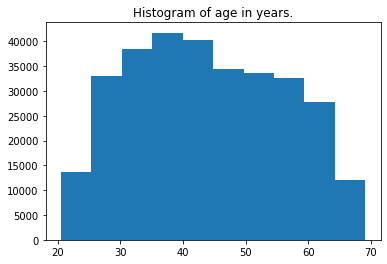

In [103]:
application_train["age"] = application_train["DAYS_BIRTH"]/ -365
plt.hist(application_train["age"]);
plt.title("Histogram of age in years.");

We can see that age distribution is almost normal and most of the people are 30~40 years.

*DAYS_EMPLOYED*

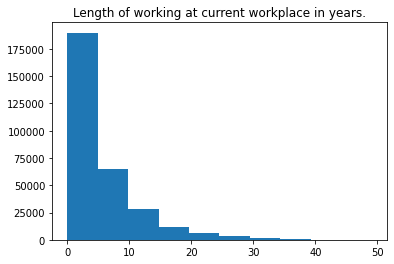

In [104]:
application_train.loc[application_train["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = 0
application_train["years_employed"] = application_train["DAYS_EMPLOYED"] / -365
plt.hist(application_train["years_employed"]);
plt.title("Length of working at current workplace in years.");

There was a strange value - 365243, it could mean empty values or some errors, so let's replace it with 0.  
A lot of people don't work, but let's look deeper into this.

In [105]:
application_train.groupby(["NAME_INCOME_TYPE"]).agg({"years_employed" : ["mean", "median", "count", "max"], "age" : ["median"]})

years_employed                                     age
                               mean    median   count        max     median
NAME_INCOME_TYPE                                                           
Businessman                7.874795  6.280822      10  14.917808  47.498630
Commercial associate       5.833627  4.147945   71617  48.071233  39.780822
Maternity leave            7.224110  8.273973       5  10.306849  39.350685
Pensioner                  0.002448 -0.000000   55362  35.246575  60.413699
State servant              9.454441  7.205479   21703  48.172603  40.693151
Student                    6.835160  5.069863      18  21.931507  36.663014
Unemployed                 0.000000 -0.000000      22  -0.000000  45.860274
Working                    6.446909  4.427397  158774  49.073973  39.876712

Well, it seems that a lot of non-working people are pensioners, which is normal. As for working people - they seem to work for several years at one place.   

There are so many features and so many possible angles from which we can analyze the. Let's see this for example:

In [106]:
application_train.groupby(["NAME_EDUCATION_TYPE", "NAME_INCOME_TYPE"]).agg({"AMT_INCOME_TOTAL" : ["mean", "median", "count", "max"]})

AMT_INCOME_TOTAL  \
                                                               mean   
NAME_EDUCATION_TYPE           NAME_INCOME_TYPE                        
Academic degree               Commercial associate    274688.372093   
                              Pensioner               203919.230769   
                              State servant           258847.826087   
                              Working                 226312.500000   
Higher education              Businessman             652500.000000   
                              Commercial associate    242283.998486   
                              Maternity leave         195000.000000   
                              Pensioner               171455.114974   
                              State servant           207116.161080   
                              Student                 231000.000000   
                              Unemployed              189000.000000   
                              Working                 194013.110125   
Incomplete higher             Commercial associate    206232.296029   
                              Pensioner               149437.155405   
                              State servant           173589.989610   
                              Student                 157500.000000   
                              Unemployed              126000.000000   
                              Working                 170659.490600   
Lower secondary               Commercial associate    168173.628261   
                              Pensioner               106468.010464   
                              State servant           143250.000000   
                              Working                 140070.652174   
Secondary / secondary special Commercial associate    181368.704601   
                              Maternity leave          58500.000000   
                              Pensioner               130863.482560   
                              State servant           159979.349061   
                              Student                 138681.818182   
                              Unemployed               70753.846154   
                              Working                 154261.801730   

                                                                       \
                                                       median   count   
NAME_EDUCATION_TYPE           NAME_INCOME_TYPE                          
Academic degree               Commercial associate  247500.00      43   
                              Pensioner             155700.00      26   
                              State servant         225000.00      23   
                              Working               202500.00      72   
Higher education              Businessman           495000.00      10   
                              Commercial associate  202500.00   24025   
                              Maternity leave       135000.00       3   
                              Pensioner             148500.00    8188   
                              State servant         180000.00    8863   
                              Student               175500.00       6   
                              Unemployed            180000.00       6   
                              Working               174134.25   33762   
Incomplete higher             Commercial associate  180000.00    3400   
                              Pensioner             135000.00     518   
                              State servant         157500.00     770   
                              Student               157500.00       1   
                              Unemployed             63000.00       3   
                              Working               157500.00    5585   
Lower secondary               Commercial associate  144000.00     460   
                              Pensioner              90000.00    1529   
                              State servant         119250.00     102   
                          

We can see that most of the loans are taken by working people with secondary education.

## Transforming and merging data

In [107]:
application_train["AMT_INCOME_TOTAL"] = np.log1p(application_train["AMT_INCOME_TOTAL"])
application_train["AMT_CREDIT"] = np.log1p(application_train["AMT_CREDIT"])
application_train["OWN_CAR_AGE"] = application_train["OWN_CAR_AGE"].fillna(0)
application_train["app AMT_CRE / AMT_ANNUITY"] = application_train["AMT_CREDIT"]/application_train["AMT_ANNUITY"]
application_train["app EXT_SOURCE mean"] = application_train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis=1)
application_train["app EXT_SOURCE_1 / DAYS_BIRTH"] = application_train["EXT_SOURCE_1"]/application_train["DAYS_BIRTH"]
application_train["app AMT_INCOME_TOTAL . 12 - AMT_ANNUITY"] = application_train["AMT_INCOME_TOTAL / AMT_ANNUITY"] = application_train["AMT_INCOME_TOTAL"]/12. - application_train["AMT_ANNUITY"]
application_train["app AMT_INCOME_TOTAL / AMT_ANNUITY"] = application_train["AMT_INCOME_TOTAL"]/application_train["AMT_ANNUITY"]
application_train["app AMT_INCOME_TOTAL - AMT_GOODS_PRICE"] = application_train["AMT_INCOME_TOTAL"] - application_train["AMT_GOODS_PRICE"]

In [108]:
application_train['AMT_INCOME_TOTAL'] = np.log1p(application_train['AMT_INCOME_TOTAL'])
application_train['AMT_CREDIT'] = np.log1p(application_train['AMT_CREDIT'])
application_train['OWN_CAR_AGE'] = application_train['OWN_CAR_AGE'].fillna(0)
application_train['app AMT_CREDIT / AMT_ANNUITY'] = application_train['AMT_CREDIT'] / application_train['AMT_ANNUITY']
application_train['app EXT_SOURCE mean'] = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
application_train['app EXT_SOURCE_1 / DAYS_BIRTH'] = application_train['EXT_SOURCE_1'] / application_train['DAYS_BIRTH']
application_train['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = application_train['AMT_INCOME_TOTAL'] / 12. - application_train['AMT_ANNUITY']
application_train['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = application_train['AMT_INCOME_TOTAL'] / application_train['AMT_ANNUITY']
application_train['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = application_train['AMT_INCOME_TOTAL'] - application_train['AMT_GOODS_PRICE']

In [109]:
application_test.loc[application_test["OBS_30_CNT_SOCIAL_CIRCLE"] > 1, "OBS_30_CNT_SOCIAL_CIRCLE"] = "1+"
application_test.loc[application_test["DEF_30_CNT_SOCIAL_CIRCLE"] > 1, "DEF_30_CNT_SOCIAL_CIRCLE"] = "1+"
application_test.loc[application_test["OBS_60_CNT_SOCIAL_CIRCLE"] > 1, "OBS_60_CNT_SOCIAL_CIRCLE"] = "1+"
application_test.loc[application_test["DEF_60_CNT_SOCIAL_CIRCLE"] > 1, "DEF_60_CNT_SOCIAL_CIRCLE"] = "1+"
np.log1p(application_test["AMT_INCOME_TOTAL"])
np.log1p(application_test["AMT_CREDIT"])
application_test["age"] = application_test["DAYS_BIRTH"] / -365
application_test.loc[application_test["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = 0
application_test["years_employed"] = application_test["DAYS_EMPLOYED"] / -365
application_test["AMT_INCOME_TOTAL"] = np.log1p(application_test["AMT_INCOME_TOTAL"])
application_test["AMT_CREDIT"] = np.log1p(application_test["AMT_CREDIT"])
application_test["OWN_CAR_AGE"] = application_test["OWN_CAR_AGE"].fillna(0)
application_test["app AMT_CREDIT / AMT_ANNUITY"] = application_test["AMT_CREDIT"] / application_test["AMT_ANNUITY"]
application_test["app EXT_SOURCE mean"] = application_test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].mean(axis = 1)
application_test["app EXT_SOURCE_1 / DAYS_BIRTH"] = application_test["EXT_SOURCE_1"] / application_test["DAYS_BIRTH"]
application_test["app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY"] = application_test["AMT_INCOME_TOTAL"] / 12. - application_test["AMT_ANNUITY"]
application_test["app AMT_INCOME_TOTAL / AMT_ANNUITY"] = application_test["AMT_INCOME_TOTAL"] / application_test["AMT_ANNUITY"]
application_test["app AMT_INCOME_TOTAL - AMT_GOODS_PRICE"] = application_test["AMT_INCOME_TOTAL"] - application_test["AMT_GOODS_PRICE"]

In [110]:
for col in ['FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
           'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
            'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START']:
    unique_values = list(set(list(application_train[col].astype(str).unique()) + list(application_test[col].astype(str).unique())))
    le.fit(unique_values)
    application_train[col] = le.transform(application_train[col].astype(str))
    application_test[col] = le.transform(application_test[col].astype(str))


In [111]:
train = application_train

train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,contact_info,age,years_employed,app AMT_CRE / AMT_ANNUITY,app EXT_SOURCE mean,app EXT_SOURCE_1 / DAYS_BIRTH,app AMT_INCOME_TOTAL . 12 - AMT_ANNUITY,AMT_INCOME_TOTAL / AMT_ANNUITY,app AMT_INCOME_TOTAL / AMT_ANNUITY,app AMT_INCOME_TOTAL - AMT_GOODS_PRICE,app AMT_CREDIT / AMT_ANNUITY,app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY
0,100002,1,0,1,0,1,0,2.581617,2.633009,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,0.0,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,3,0,0.0149,5,0,1,1,1,1,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,4,25.920548,1.745205,0.000523,0.161787,-0.000009,-24699.481792,-24699.481792,0.000105,-3.509974e+05,0.000107,-24700.284865
1,100003,0,0,0,0,0,0,2.603147,2.712896,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,0.0,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,3,0,0.0714,0,0,2,0,2,0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4,45.931507,3.254795,0.000394,0.466757,-0.000019,-35697.457818,-35697.457818,0.000073,-1.129497e+06,0.000076,-35698.283071
2,100004,0,1,1,1,1,0,2.494849,2.550463,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,

In [112]:
test = application_test
test = test.fillna(0)

X = train.drop(["SK_ID_CURR", "contact_info", "TARGET"], axis=1)
y = train["TARGET"]
X_test = test.drop(["SK_ID_CURR"], axis=1)

### Basic modelling, LGB

In [113]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
params = {
    "boosting" : "dart",
    "application" : "binary",
    "learning_rate" : 0.01,
    "num_leaves" : 34,
    "max_depth" : 5,
    "feature_fraction" : 0.9,
    "scale_pos_weight" : 2,
    "reg_alpha" : 0.05,
    "reg_lambda" : 0.1
}
model = lgb.train(params, lgb.Dataset(X_train, y_train), 1000, [lgb.Dataset(X_train, y_train), lgb.Dataset(X_valid, y_valid)], verbose_eval=10, early_stopping_rounds=20)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14070
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 126
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:182: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[10]	valid_0's binary_logloss: 0.274241	valid_1's binary_logloss: 0.273469
[20]	valid_0's binary_logloss: 0.270071	valid_1's binary_logloss: 0.269377
[30]	valid_0's binary_logloss: 0.267819	valid_1's binary_logloss: 0.267242
[40]	valid_0's binary_logloss: 0.266689	valid_1's binary_logloss: 0.266153
[50]	valid_0's binary_logloss: 0.275477	valid_1's binary_logloss: 0.275066
[60]	valid_0's binary_logloss: 0.293029	valid_1's binary_logloss: 0.292764
[70]	valid_0's binary_logloss: 0.314471	valid_1's binary_logloss: 0.314322
[80]	valid_0's binary_logloss: 0.311194	valid_1's binary_logloss: 0.311037
[90]	valid_0's binary_logloss: 0.309308	valid_1's binary_logloss: 0.30913
[100]	valid_0's binary_logloss: 0.332121	valid_1's binary_logloss: 0.332042
[110]	valid_0's binary_logloss: 0.357372	valid_1's binary_logloss: 0.357348
[120]	valid_0's binary_logloss: 0.350451	valid_1's binary_logloss: 0.350437
[130]	valid_0's binary_logloss: 0.345974	valid_1's binary_logloss: 0.345949
[140]	valid_0's binary

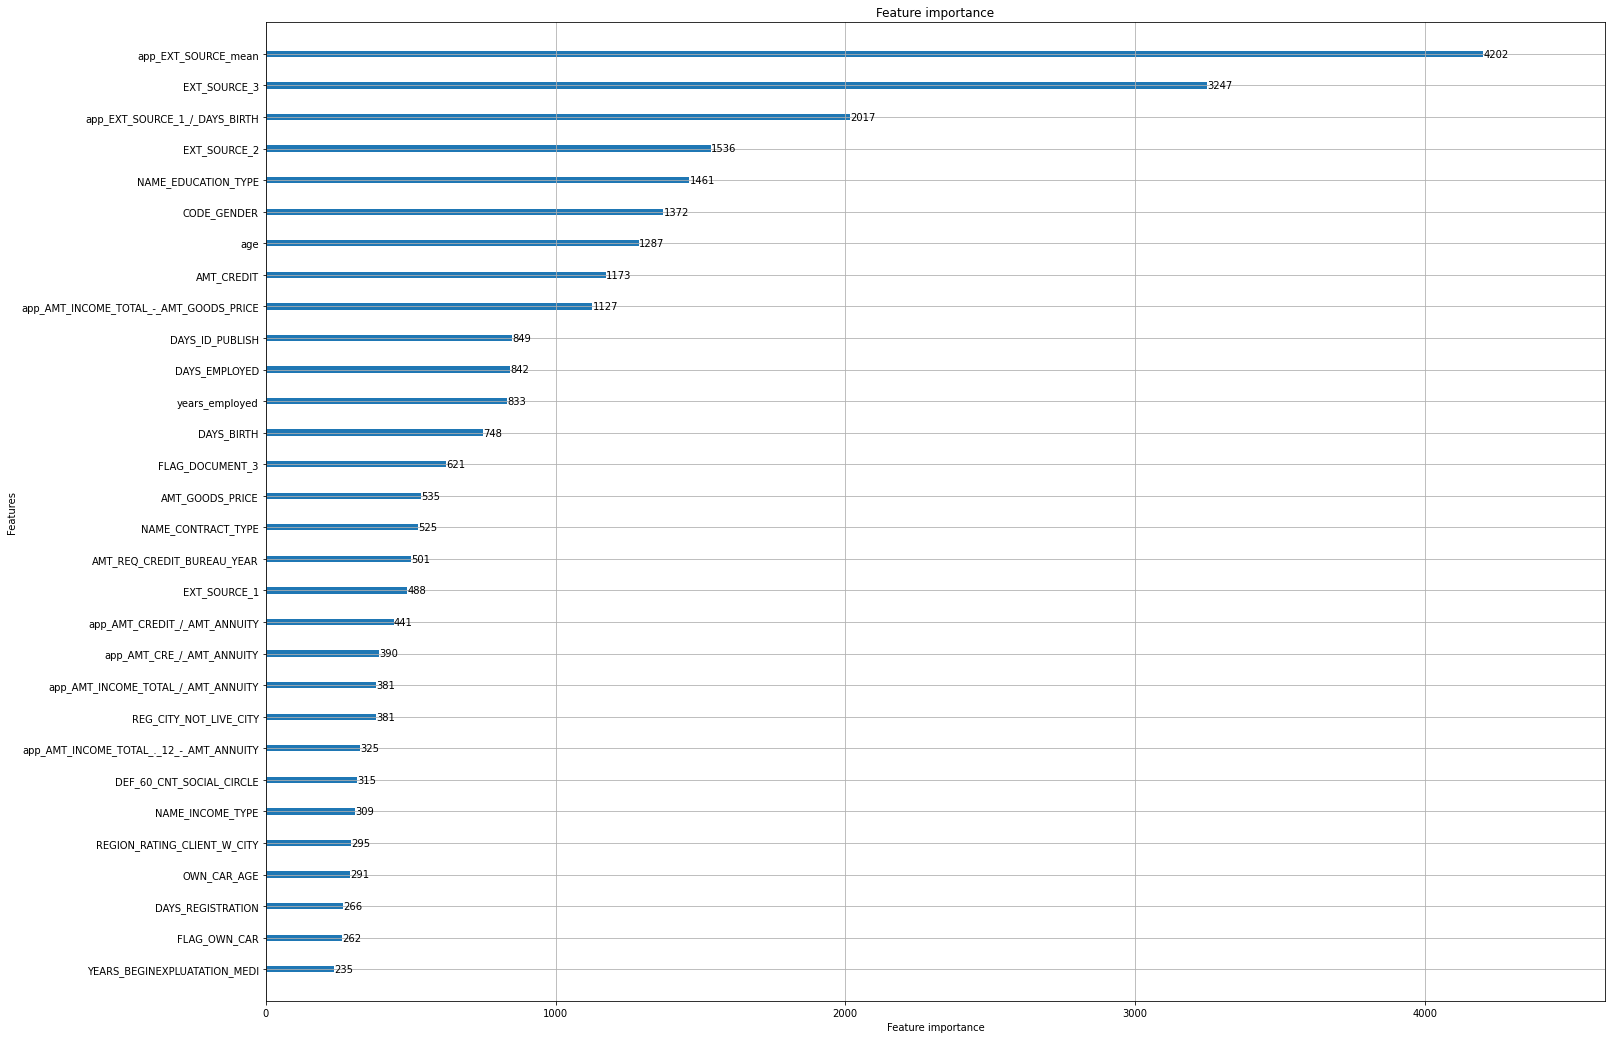

In [114]:
lgb.plot_importance(model, max_num_features=30, figsize=(24, 18));

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
params = {
    "colsample_bytree" : 0.8,
    "learning_rate" : 0.01,
    "num_leaves" : 34,
    "subsample" : 0.97,
    "max_depth" : 8,
    "reg_alpha" : 0.03,
    "reg_lambda" : 0.07,
    "min_split_gain" : 0.01,
    "min_child_weight": 38
}
prediction = np.zeros(X_test.shape[0])
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]
    clf = lgb.LGBMClassifier(**params)
    clf.fit(train_x, train_y,
            eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = "auc", verbose = 100, early_stopping_rounds = 50)
    prediction += clf.predict(X_test)

In [ ]:
sub = test[["SK_ID_CURR"]].copy()
sub["TARGET"] = prediction/10
sub.to_csv("sub.csv", index = False)